In [19]:
import pandas as pd
import numpy as np

Data Analysis

We will now load the data and take a look at the features.

In [44]:
df = pd.read_csv('data/bank-full.csv', sep=";")

We will replace 'unknown' with nan to see what we can do.

In [45]:
df=df.replace('unknown',np.nan)
df_mod=df

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

We have 41188 entries and 21 columns. The column 'y' is the one we will try to predict.
We will now take a look at the categorical columns and see the values in it.

In [46]:
no_cats = [len(set(df[col])) for col in df.columns]
pd.DataFrame({'Column': df.columns, 'Number of categories': no_cats})

,Column,Number of categories
0,age,78
1,job,12
2,marital,4
3,education,8
4,default,3
5,housing,3
6,loan,3
7,contact,2
8,month,10
9,day_of_week,5


We have very different  columns with different numbers of categories for each. We have categorical and numerical values.

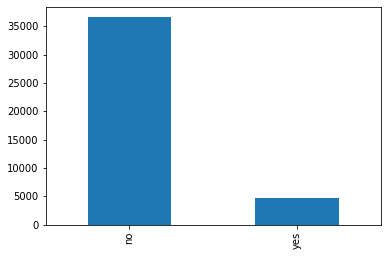

In [48]:
df['y'].value_counts().plot(kind='bar')

We have 11.2% loan accepted.

In [14]:
catCols = [columnName for columnName in df.columns if str(df[columnName].dtype) == 'object']
for col in catCols:
    print(col)
    print(df[col].value_counts())

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
housing
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
loan
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
contact
cellular     26144
telephone    15044
Name: contact, 

We can see that some values are unknwon in some categorical variables like 'default', 'loan' or 'marital'. In those 3 categories, we see that these columns have a highly represented value so we will replace the missing values by the most frequent value.

In [18]:
print(df['default'].value_counts())
print(df['loan'].value_counts())
print(df['marital'].value_counts())

no         32588
unknown     8597
yes            3
Name: default, dtype: int64
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


In [24]:
df_mod['marital'].fillna('married')
df_mod['default'].fillna('no')
df_mod['loan'].fillna('no')

0         no
1         no
2         no
3         no
4        yes
5         no
6         no
7         no
8         no
9         no
10        no
11        no
12       yes
13        no
14        no
15       yes
16        no
17       yes
18       yes
19        no
20        no
21        no
22        no
23        no
24        no
25       yes
26        no
27        no
28        no
29        no
        ... 
41158     no
41159     no
41160     no
41161     no
41162     no
41163     no
41164     no
41165     no
41166     no
41167     no
41168     no
41169     no
41170     no
41171     no
41172     no
41173     no
41174     no
41175     no
41176    yes
41177     no
41178     no
41179     no
41180     no
41181     no
41182     no
41183     no
41184     no
41185     no
41186     no
41187     no
Name: loan, Length: 41188, dtype: object

In the other categories, we don't have a high represented value so we will keep 'unknown' for these columns.

In [27]:
for col in catCols:
    df_mod[col].fillna('unknown')

We will now take a look at the numerical columns.

In [28]:
catNum = [columnName for columnName in df.columns if columnName not in catCols]

In [52]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


We can notice that age distribution is concentrated between 25 and 50. Maybe we can try later to create categories of age instead of taking all possible ages. Duration has very high values so maybe we will need to limit this.
Concerning pdays, we see that more than 75% of people were never contacted before for a loan so maybe it would be better to create a variable with contacted before instead of this representation.

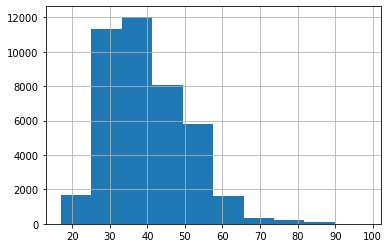

In [37]:
df_mod['age'].hist()

Customer View

In [ ]:
Time representation

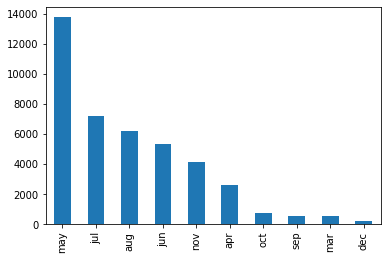

In [49]:
df['month'].value_counts().plot(kind='bar')

We see that some months are more represented than others.

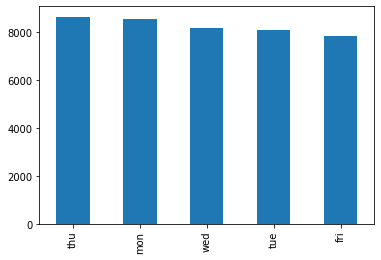

In [50]:
df['day_of_week'].value_counts().plot(kind='bar')

Days of the week are equally represented in the dataset.